In [144]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
RANDOM_SEED = 17
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Current device {DEVICE}')

Current device cpu


In [13]:
names1 = [name.split('.')[0] for name in os.listdir('samples') if '.' in name]
names2 = [name.split('.')[0] for name in os.listdir('samples/samples') if '.' in name]

In [14]:
chars = list("".join(names1))
chars = sorted(np.unique(chars))

In [15]:
id_to_ch = {i + 1: ch for i, ch in enumerate(chars)}
id_to_ch[0] = "-"
ch_to_id = {ch: i for i, ch in id_to_ch.items()}

In [98]:
ch_to_id

{'2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 'b': 8,
 'c': 9,
 'd': 10,
 'e': 11,
 'f': 12,
 'g': 13,
 'm': 14,
 'n': 15,
 'p': 16,
 'w': 17,
 'x': 18,
 'y': 19,
 '-': 0}

In [99]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [100]:
class CaptchaDataset(torch.utils.data.Dataset):

    def __init__(self, dir_path, image_paths, transform=None, encode_table=None):
        self.dir_path = dir_path
        self.transform = transform
        self.encode_table = encode_table
        self.image_paths_id = []
        self.image_paths = image_paths
    
    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, index):
        path_to_image = self.image_paths[index]
        label = path_to_image.split('.')[0]
        if self.encode_table:
            label = torch.tensor([self.encode_table[ch] for ch in label], dtype=torch.long)

        with Image.open(self.dir_path + '/' + path_to_image).convert('RGB') as img:
            img.load()
        
        if self.transform:
            img = self.transform(img)

        return (img, label)
    



In [101]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = "samples"

image_paths = [name for name in os.listdir(data_dir) if '.' in name]

train_paths, test_paths = train_test_split(image_paths, shuffle=True, test_size=0.2, random_state=RANDOM_SEED)

batch_size = 4
num_workers = 0

trainset = CaptchaDataset(dir_path=data_dir, image_paths=train_paths, encode_table=ch_to_id, transform=transform)
testset = CaptchaDataset(dir_path=data_dir, image_paths=test_paths, encode_table=ch_to_id, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
                                    
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=num_workers)


In [102]:
len(trainset), len(testset)

(856, 214)

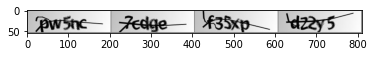

tensor([16, 17,  4, 15,  9])  tensor([ 6,  9, 10, 13, 11])  tensor([12,  2,  4, 18, 16])  tensor([10,  1,  1, 19,  4])


In [112]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images), labels)
print('  '.join('{}'.format(labels[j]) for j in range(batch_size)))

### Модель

In [145]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2)
        )

        self.linear_1 = nn.Linear(832, 128)
        self.lstm = nn.LSTM(128, 32, bidirectional=True, batch_first=True)
        self.linear_2 = nn.Linear(64, 20)

    def forward(self, x, targets):
        bs, _, _, _ = x.size()
        x = self.conv_layers(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.linear_1(x)
        x = nn.functional.relu(x)
        x, h = self.lstm(x)
        x = self.linear_2(x)
        x = x.permute(1, 0, 2)
        
        loss = None

        if targets is not None:
            log_probs = nn.functional.log_softmax(x, 2)

            input_lengths = torch.full(
                size=(bs,),
                fill_value=log_probs.size(0),
                dtype=torch.int32
            )

            target_lengths = torch.full(
                size=(bs,),
                fill_value=targets.size(1),
                dtype=torch.int32
            )
            
            loss = nn.CTCLoss(blank=19)(log_probs, targets, input_lengths, target_lengths)

        return x, loss

In [146]:
net = Net()

In [147]:
import torch.optim as optim

optimizer =  optim.Adam(net.parameters(), lr=1e-4)

In [148]:
def train(model, optimizer, train_loader, test_loader, encoder, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):

        # train
        model.train()
        sum_loss = 0
        for images, targets in train_loader:
            optimizer.zero_grad()
            targets = targets.to(DEVICE)
            images = images.to(DEVICE)              
            train_pred, loss = model(images, targets)
            loss.requres_grad = True
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            loss.detach()

        train_loss = sum_loss / len(train_loader)          
        train_losses.append(train_loss)         

        # validation eval                     
        model.eval()
        sum_loss = 0
        with torch.no_grad():
            for images, targets in test_loader:
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                val_pred, loss = model(images, targets)
                loss.requres_grad = True
                sum_loss += loss.item()

        val_loss = sum_loss / len(test_loader)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, train loss: {r4(train_loss)},  val. loss: {r4(val_loss)}")

    return train_losses, val_losses

In [ ]:
model = Net()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=2E-3)
num_epochs = 90

train_loss, val_loss = train(model, optimizer, trainloader, testloader, label_encoder, num_epochs)

In [ ]:
def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label = 'training')
    plt.plot(val_loss, label = 'validation')
    plt.grid()
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_losses(train_loss, val_loss)

In [ ]:
def decode(batch_outputs, encoder):
    predictions_labels = []
    for j in range(batch_outputs.shape[1]):
        model_output = batch_outputs[:, j, :].unsqueeze(1)
        
        model_output_permuted = model_output.permute(1, 0, 2)
        model_output_converted_to_probabilities = torch.softmax(model_output_permuted, 2)
        model_output_BPA_applied_gpu = torch.argmax(model_output_converted_to_probabilities, 2)
        model_output_BPA_applied = model_output_BPA_applied_gpu.detach().cpu().numpy().squeeze()

        prediction_ctc = []
        for n in model_output_BPA_applied:
            if n == 19:
                prediction_ctc.append("_")
            else:
                c = encoder.inverse_transform([n])[0]
                prediction_ctc.append(c)

        model_ouput_without_dublicates = []
        for i in range(len(prediction_ctc)):
            if i == 0:
                model_ouput_without_dublicates.append(prediction_ctc[i])
            else:
                if model_ouput_without_dublicates[-1] != prediction_ctc[i]:
                    model_ouput_without_dublicates.append(prediction_ctc[i])

        model_ouput_without_blanks = []
        for e in model_ouput_without_dublicates:
            if e != "_":
                model_ouput_without_blanks.append(e)
        prediction_label = "".join(model_ouput_without_blanks)
        predictions_labels.append(prediction_label)

    return predictions_labels

In [ ]:
def evaluations(model, test_loader, encoder):
    model.eval()
    cer_loss = CharErrorRate()
    predictions = []
    pred_labels = []    
    test_labels = []
    test_img = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            test_pred, loss = model(images, targets)
            predictions.append(test_pred.detach())

    for pred in predictions:
        pred_labels.extend(decode(pred, encoder))

    for images, labels in test_loader:
        for ind, label in enumerate(labels):
            label = label.type(torch.int).tolist()
            test_labels.append(''.join(encoder.inverse_transform(label)))
            test_img.append(images[ind].squeeze())
      
    test_cer_loss = cer_loss(pred_labels, test_labels).item()        
    test_result_summary = []
    for ind in range(len(test_labels)):
        img = test_img[ind]
        summary = dict()
        summary["data"] = img
        summary["char_err"] = cer_loss(pred_labels[ind], test_labels[ind]).item()
        summary["label"] = test_labels[ind]
        summary["prediction"] = pred_labels[ind]
        test_result_summary.append(summary)

    return test_cer_loss, test_result_summary

In [ ]:
test_cer_loss, test_result_summary = evaluations(model, test_loader, label_encoder)
print(f"CharErrorRate: {test_cer_loss}")

In [ ]:
quantity = 5
test_result_summary = sorted(test_result_summary, key=lambda x: x["char_err"], reverse=True)
for img in test_result_summary[:quantity]:
    print(f"        Label: {img['label']}\n   Prediction: {img['prediction']}")
    print(f"CharErrorRate: {r4(img['char_err'])}")
    plt.imshow(img["data"], cmap="gray")
    plt.show()